In [1]:
#!pip install torch torchvision torchaudio
#!pip install captum

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torchvision
from torchvision import models
from torchvision import transforms
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [3]:
# check if CUDA is available
train_on_gpu = False
# uncomment if you want to us the GPU
# train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [4]:
# download & load resnet
model = models.resnet18(pretrained=True)
model = model.eval()

# move model to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# You need to download the following dataset:
# Kaggle Cats and Dogs Dataset
# https://www.microsoft.com/en-us/download/details.aspx?id=54765

# Download the class labels from imagenet
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

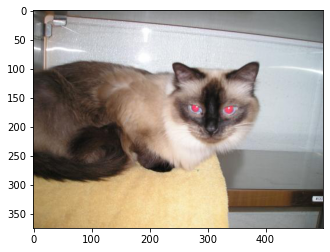

In [7]:
# Load one cat image
# https://captum.ai/tutorials/Resnet_TorchVision_Interpret

img = Image.open('dogs_cats_dataset/PetImages/Cat/20.jpg')
plt.imshow(img)

In [8]:
# Load ImageNet class labels
labels_path = 'dogs_cats_dataset/imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = json.load(json_data)

In [9]:
# image transformation
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
transform_normalize = transforms.Normalize(mean.tolist(), std.tolist()) 

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transform_normalize
])

In [10]:
# prepare image for pytorch
img_input = transform(img)
img_input = img_input.unsqueeze(0)
img_input.requires_grad = True

if train_on_gpu:
    img_input = img_input.cuda()

In [11]:
# Predict the label of the image
output = model(img_input)
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)

pred_label_idx.squeeze_()
predicted_label = idx_to_labels[str(pred_label_idx.item())][1]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Siamese_cat ( 0.9938308000564575 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Approximation delta:  tensor([0.1716, 0.2360, 0.1806, 0.6273, 0.0438], dtype=torch.float64)


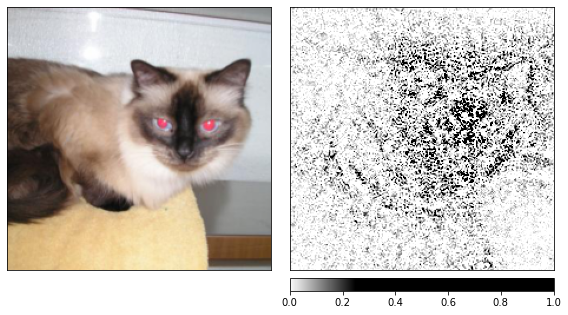

In [12]:
# get pixel attribution
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig, delta = nt.attribute(img_input, target=pred_label_idx,  baselines=img_input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

# unnormalize image
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
img_unn = unnormalize(img_input.squeeze().cpu().detach())
img_unn = np.transpose(img_unn.numpy(), (1, 2, 0))

# black & white color map
default_cmap = LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#000000'),
                                                  (1, '#000000')], N=256)
# visualize
_ = viz.visualize_image_attr_multiple(attr_ig, img_unn, 
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=default_cmap,
                                      show_colorbar=True)